In [3]:
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

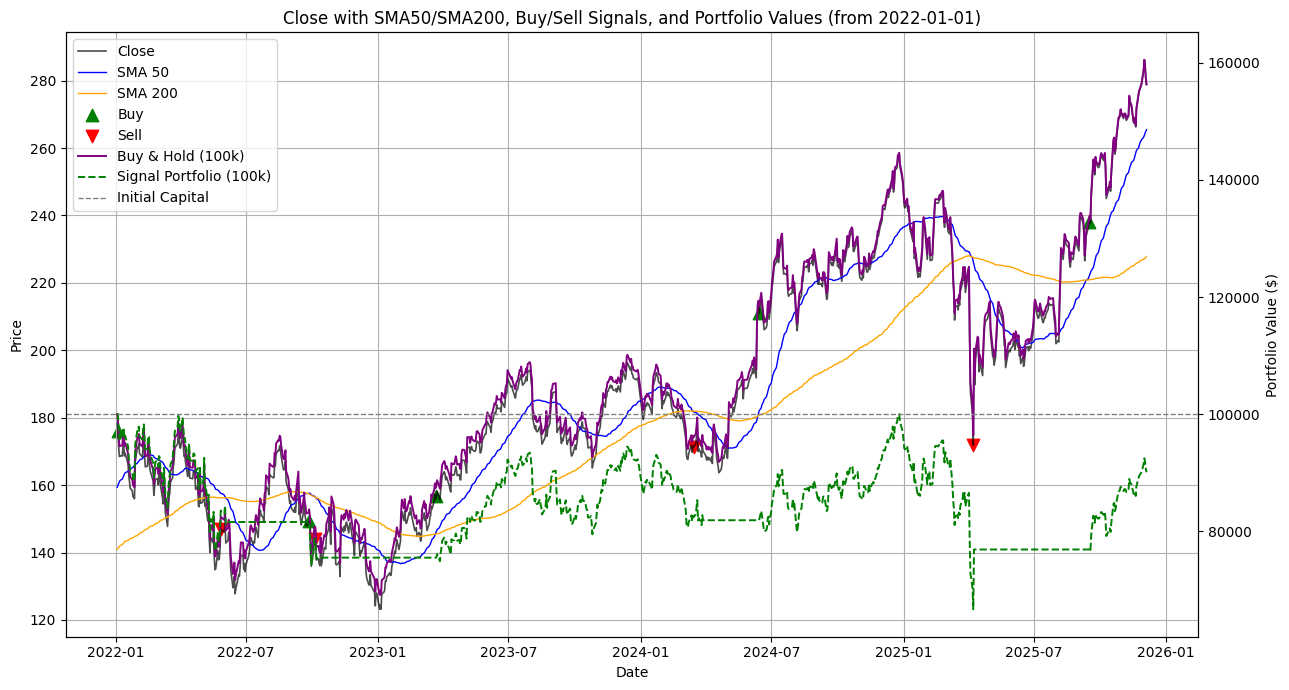

In [15]:
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========= 1. Load prices + SMAs from data_processed.sqlite =========
price_db = Path("data") / "processed" / "data_processed.sqlite"

with sqlite3.connect(price_db) as conn:
    tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
    if tables.empty:
        raise RuntimeError(f"No tables found in {price_db}")
    table_name = tables["name"].iloc[0]

    price_df = pd.read_sql(
        f'SELECT Date, Close, SMA50, SMA200 FROM "{table_name}"',
        conn,
        parse_dates=["Date"],
    )

price_df = price_df.set_index("Date").sort_index().dropna(subset=["Close", "SMA50", "SMA200"])

# ========= 2. Load combined signal from combined.sqlite =========
signals_db = Path("data") / "signals" / "combined.sqlite"

with sqlite3.connect(signals_db) as conn:
    sig_df = pd.read_sql("SELECT Date, signal_combined FROM signals_combined",
                         conn, parse_dates=["Date"])

sig_df = sig_df.set_index("Date").sort_index()

# ========= 3. Merge price + SMAs + signal =========
df = price_df.join(sig_df, how="inner")
df["signal_combined"] = df["signal_combined"].fillna(0).astype(int)

# --- filter start date 2022-01-01 ---
start_date = pd.Timestamp("2022-01-01")
df = df.loc[df.index >= start_date]

# ========= 4. Backtest portfolios (100k) using signal =========
initial_capital = 100_000.0
cash = initial_capital
shares = 0.0
portfolio_signal = []

trade_signal = df["signal_combined"].shift(1).fillna(0).astype(int)

for price, sig in zip(df["Close"], trade_signal):
    if sig == 1 and shares == 0:
        shares = cash / price
        cash = 0.0
    elif sig == -1 and shares > 0:
        cash = shares * price
        shares = 0.0
    portfolio_signal.append(cash + shares * price)

df["portfolio_signal"] = portfolio_signal

bh_shares = initial_capital / df["Close"].iloc[0]
df["portfolio_buyhold"] = bh_shares * df["Close"]

# ========= 5. Derive buy/sell points for arrows =========
position = trade_signal
prev_pos = position.shift(1).fillna(0)

buy_mask = (prev_pos <= 0) & (position > 0)
sell_mask = (prev_pos > 0) & (position <= 0)

buys = df[buy_mask]
sells = df[sell_mask]

# ========= 6. Combined plot =========
fig, ax_price = plt.subplots(figsize=(13, 7))

ax_price.plot(df.index, df["Close"], label="Close", color="black", linewidth=1.2, alpha=0.7)
ax_price.plot(df.index, df["SMA50"], label="SMA 50", color="blue", linewidth=1.0)
ax_price.plot(df.index, df["SMA200"], label="SMA 200", color="orange", linewidth=1.0)

ax_price.scatter(buys.index, buys["Close"], marker="^", color="green", s=80, label="Buy")
ax_price.scatter(sells.index, sells["Close"], marker="v", color="red", s=80, label="Sell")

ax_price.set_xlabel("Date")
ax_price.set_ylabel("Price")
ax_price.grid(True)

ax_eq = ax_price.twinx()
ax_eq.plot(df.index, df["portfolio_buyhold"], label="Buy & Hold (100k)", color="purple", linewidth=1.4)
ax_eq.plot(df.index, df["portfolio_signal"], label="Signal Portfolio (100k)", color="green", linewidth=1.4, linestyle="--")
ax_eq.set_ylabel("Portfolio Value ($)")
ax_eq.axhline(initial_capital, color="gray", linestyle="--", linewidth=1, label="Initial Capital")

lines1, labels1 = ax_price.get_legend_handles_labels()
lines2, labels2 = ax_eq.get_legend_handles_labels()
ax_price.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Close with SMA50/SMA200, Buy/Sell Signals, and Portfolio Values (from 2022-01-01)")
plt.tight_layout()
plt.show()